In [1]:
%matplotlib inline
from pprint import pprint
from decimal import Decimal
import pandas

import plot
import simulate
import harvesting
import market
import withdrawal
import metrics

First we want to calculate the Maximum Safe Withdrawal Rate (MSWR) for every length of retirement from 1 year up to 60 years.

In [2]:
US = market.Returns_US_1871()

In [3]:
def find_mswr(length, stock_pct=Decimal('.6')):
    bond_pct = 1 - stock_pct
    mswrs = []
    for start_year in range(US.start_year, 2017 - length):
        returns = []
        for annual_returns in US.iter_from(start_year, length=length):
                stocks = ((1 + annual_returns.stocks) / (1 + annual_returns.inflation) - 1)
                bonds = ((1 + annual_returns.bonds) / (1 + annual_returns.inflation) - 1)
                returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        pwa = metrics.pwa(1, 0, returns)
        mswrs.append(pwa)
    return min(mswrs)

In [4]:
def find_all_mswrs():
    s = pandas.Series()
    for length in range(1, 61):
        mswr = find_mswr(length)
        s.loc[length] = mswr
    return s

In [5]:
MSWRs = find_all_mswrs()

<ipython-input-4-1f9ff1e6012c>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pandas.Series()


In [6]:
YEARS = 40
RATE = Decimal('.0325')

Now we want to re-run the simulation. But every year, we want see if our current withdrawal rate exceeds the MSWR for our remaining retirement length. That is, when we have 14 years left, is our current withdrawal rate exceeding the MSWR for 14-year retirement?

In [7]:
def run_one(start_year):
    yearlies = simulate.withdrawals(US.iter_from(start_year),
                         years=YEARS,
                         harvesting=harvesting.N_60_RebalanceHarvesting,
                         withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=RATE))
    withdraw_pct = [r.withdraw_pct_cur for r in yearlies]

    total = 0
    failed = 0
    for i in range(1, YEARS+1):
        actual = withdraw_pct[i-1]
        maximum = MSWRs.loc[YEARS - i + 1]
        if actual > maximum:
            failed += 1
        total += 1
    return (failed, total)

failed = 0
total = 0
for year in range(US.start_year, 2017-YEARS):
    f, t = run_one(year)
    print(year, f, t)
#    if f >= 1:
#        failed += 1
#    total += 1
    failed += f
    total += t
print(failed, total, failed/total)

1871 0 40
1872 0 40
1873 0 40
1874 0 40
1875 0 40
1876 0 40
1877 0 40
1878 0 40
1879 0 40
1880 0 40
1881 0 40
1882 0 40
1883 0 40
1884 0 40
1885 0 40
1886 0 40
1887 0 40
1888 0 40
1889 0 40
1890 0 40
1891 0 40
1892 0 40
1893 0 40
1894 0 40
1895 0 40
1896 0 40
1897 0 40
1898 1 40
1899 6 40
1900 1 40
1901 5 40
1902 8 40
1903 5 40
1904 4 40
1905 8 40
1906 14 40
1907 10 40
1908 5 40
1909 10 40
1910 9 40
1911 12 40
1912 13 40
1913 9 40
1914 8 40
1915 7 40
1916 11 40
1917 8 40
1918 2 40
1919 1 40
1920 0 40
1921 0 40
1922 0 40
1923 0 40
1924 0 40
1925 0 40
1926 0 40
1927 0 40
1928 2 40
1929 4 40
1930 2 40
1931 2 40
1932 0 40
1933 0 40
1934 0 40
1935 0 40
1936 4 40
1937 14 40
1938 0 40
1939 7 40
1940 7 40
1941 4 40
1942 0 40
1943 0 40
1944 0 40
1945 2 40
1946 6 40
1947 0 40
1948 0 40
1949 0 40
1950 0 40
1951 0 40
1952 0 40
1953 0 40
1954 0 40
1955 0 40
1956 0 40
1957 0 40
1958 0 40
1959 1 40
1960 1 40
1961 2 40
1962 11 40
1963 8 40
1964 11 40
1965 15 40
1966 19 40
1967 13 40
1968 20 40
1969 20

In [8]:
def fmt_pct(p):
    pflt = float(p) * 100
    return ('%.1f%%' % pflt)

In [9]:
RETIRE_YEAR = 1966

In [10]:
yearlies = simulate.withdrawals(US.iter_from(RETIRE_YEAR),
                     years=YEARS,
                     harvesting=harvesting.N_60_RebalanceHarvesting,
                     withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=RATE))
withdraw_pct = [('%.1f%%' % (float(r.withdraw_pct_cur)*100), '{:,.0f}'.format(r.withdraw_n), '{:,.0f}'.format(r.portfolio_post.value_n)) for r in yearlies]
df = pandas.DataFrame(withdraw_pct, columns=['Withdraw %', 'Withdraw $', 'Portfolio $'])
df.head(5)

,Withdraw %,Withdraw $,Portfolio $
0,3.2%,"32,500","934,914"
1,3.6%,"33,624","1,047,190"
2,3.3%,"34,646","1,104,771"
3,3.3%,"36,281","1,003,242"
4,3.8%,"38,530","1,024,642"


In [11]:
withdraw_pct = [(fmt_pct(r.withdraw_pct_cur), y) for r, y in zip(yearlies, range(YEARS, 0, -1))]
df = pandas.DataFrame(withdraw_pct, columns=['Withdraw %', 'Years To Go'])
df.head(5)

,Withdraw %,Years To Go
0,3.2%,40
1,3.6%,39
2,3.3%,38
3,3.3%,37
4,3.8%,36


In [12]:
withdraw_pct = [(fmt_pct(r.withdraw_pct_cur), fmt_pct(MSWRs.loc[y+1]), y) for r, y in zip(yearlies, range(YEARS, 0, -1))]
df = pandas.DataFrame(withdraw_pct, columns=['Withdraw %', 'MSWR', 'Years To Go'])
df.head(5)

,Withdraw %,MSWR,Years To Go
0,3.2%,3.7%,40
1,3.6%,3.7%,39
2,3.3%,3.7%,38
3,3.3%,3.8%,37
4,3.8%,3.8%,36


In [13]:
df.loc[df['Withdraw %'] > df['MSWR']]

,Withdraw %,MSWR,Years To Go
5,4.0%,3.8%,35
8,4.5%,3.9%,32
9,6.2%,3.9%,31
10,5.6%,4.0%,30
11,5.2%,4.0%,29
12,5.9%,4.1%,28
13,6.4%,4.1%,27
14,6.7%,4.2%,26
15,6.7%,4.2%,25
16,7.8%,4.3%,24


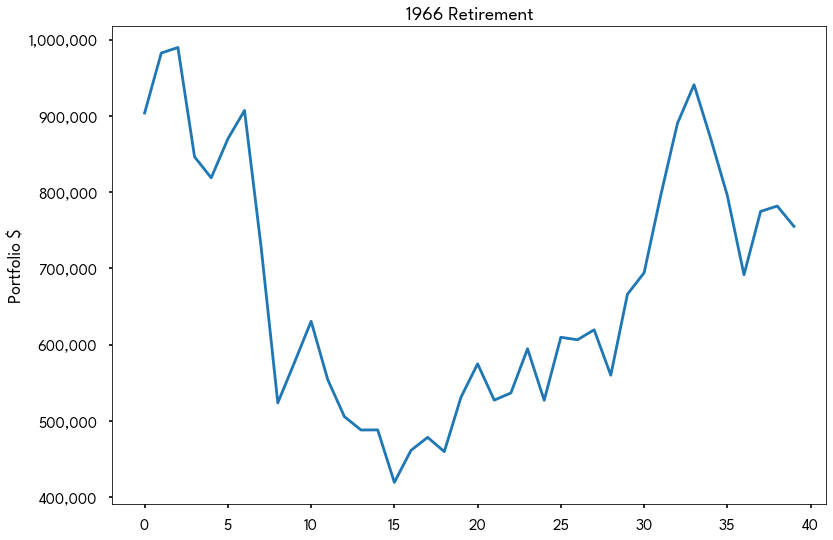

In [14]:
plot.plot([r.portfolio_post.value_r for r in yearlies], title='%s Retirement' % RETIRE_YEAR, y_label='Portfolio $')

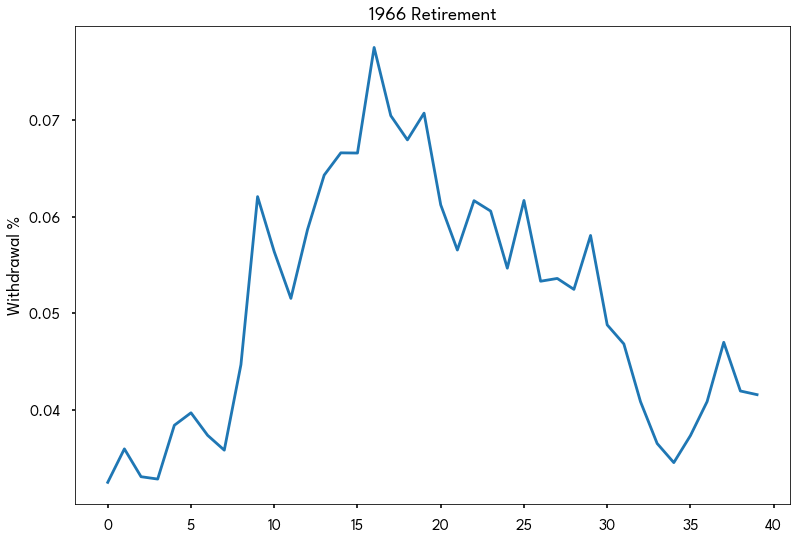

In [15]:
plot.plot([r.withdraw_pct_cur for r in yearlies], title='%s Retirement' % RETIRE_YEAR, y_label='Withdrawal %', add_commas=False)

In [16]:
["${:,.0f},".format(r.portfolio_post.value_r) for r in yearlies]

['$903,656,',
 '$982,320,',
 '$989,626,',
 '$846,236,',
 '$818,684,',
 '$869,741,',
 '$906,994,',
 '$727,427,',
 '$523,600,',
 '$576,510,',
 '$630,569,',
 '$554,014,',
 '$505,491,',
 '$487,977,',
 '$488,127,',
 '$419,322,',
 '$461,306,',
 '$478,337,',
 '$459,620,',
 '$530,863,',
 '$574,769,',
 '$527,156,',
 '$536,534,',
 '$594,523,',
 '$526,972,',
 '$609,582,',
 '$606,306,',
 '$619,370,',
 '$559,852,',
 '$666,022,',
 '$694,080,',
 '$795,603,',
 '$889,838,',
 '$940,829,',
 '$870,309,',
 '$795,458,',
 '$691,590,',
 '$774,641,',
 '$781,696,',
 '$755,038,']